In [1]:
import os, glob
import ast
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [ ]:
with open("ideas.md") as f:
    ideas = f.readlines()
# get lines starting with - or =- and remove the - or =-
ideas = [i.strip()[1:] for i in ideas if i.startswith("-") or i.startswith("=-")]
len(ideas)

In [16]:
def generate_ast_graph(node):
    """
    Recursively generate a networkx tree graph of an AST using a custom NodeVisitor class,
    retaining the order of the visit.
    """
    class Visitor(ast.NodeVisitor):
        def __init__(self):
            self.graph = nx.DiGraph()
            self.counter = 0
            self.parent = None
        
        def generic_visit(self, node):
            node_id = self.counter
            self.counter += 1
            self.graph.add_node(node_id, label=type(node).__name__)
            if self.parent is not None:
                self.graph.add_edge(self.parent, node_id)
            self.parent = node_id
            ast.NodeVisitor.generic_visit(self, node)
            self.parent = node_id
    
    visitor = Visitor()
    visitor.visit(node)
    return visitor.graph

def plot_graph(graph, label=0, ax=None):
    # Draw graph
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")

    # Create the title for the ax, not a new figure
    if ax is not None:
        ax.set_title(label, fontsize=12)
    else:
        plt.title(label, fontsize=12)
    nx.draw(
        graph,
        labels=nx.get_node_attributes(graph, "label"),
        font_weight="bold",
        node_size=200,
        node_color="skyblue",
        pos=pos,
        font_size=5,
        width=3,
        edge_color="black",
        arrowsize=5,
        arrowstyle="-|>",
        arrows=True,
        alpha=0.5,
        linewidths=1.5,
        style="dashed",
        ax=ax,  # draw on the passed in ax
    )

In [2]:
CWD = os.getcwd()
CHATGPT_DIR = os.path.join(CWD, '3.5turbo')
files = glob.glob(os.path.join(CHATGPT_DIR, '**/*.py'), recursive=True)
ChatGPT_dirs = [f.split("3.5turbo")[1].split("/") for f in files]
ChatGPT_df = pd.DataFrame(ChatGPT_dirs, columns=['Preamble', 'Category', 'Subcategory', 'Filename'], index = None)
ChatGPT_df.head()

,Preamble,Category,Subcategory,Filename
0,,data-analysis,statistics,determines-how-far-each-number-in-a-list-of-nu...
1,,data-analysis,statistics,finds-the-standard-deviation-of-a-list-of-numb...
2,,data-analysis,statistics,when-given-a-list-of-numbers-determines-how-fa...
3,,data-analysis,statistics,finds-the-mean-median-mode-and-range-of-a-list...
4,,data-analysis,statistics,finds-the-outliers-in-a-data-set.py


In [3]:
CWD = os.getcwd()
humanCode_DIR = os.path.join(CWD, 'humanCode')
files = glob.glob(os.path.join(humanCode_DIR, '**/*.py'), recursive=True)
humanCode_dirs = [f.split("humanCode")[1].split("/") for f in files]
humanCode_df = pd.DataFrame(humanCode_dirs, columns=['Preamble', 'Category', 'Subcategory', 'Filename'], index = None)
humanCode_df

,Preamble,Category,Subcategory,Filename
0,,data-analysis,statistics,determines-how-far-each-number-in-a-list-of-nu...
1,,data-analysis,statistics,finds-the-standard-deviation-of-a-list-of-numb...
2,,data-analysis,statistics,when-given-a-list-of-numbers-determines-how-fa...
3,,data-analysis,statistics,finds-the-mean-median-mode-and-range-of-a-list...
4,,data-analysis,statistics,finds-the-outliers-in-a-data-set.py
...,...,...,...,...
102,,visual-graphical-drawing,drawing-common-objects,uses-the-python-turtle-module-draw-a-smiley-fa...
103,,visual-graphical-drawing,drawing-common-objects,uses-the-python-turtle-module-to-draw-a-simple...
104,,visual-graphical-drawing,drawing-common-objects,prints-a-half-diamond-star-pattern-using-text-...
105,,visual-graphical-drawing,drawing-common-objects,uses-the-python-turtle-module-to-draw-the-lett...


In [4]:
ChatGPT_df.groupby(['Category', 'Subcategory']).count()['Filename']

Category                    Subcategory                             
algorithms-data-structures  code-optimization-time-complexity            1
                            general                                     23
                            implementation                               5
                            recursion                                    5
data-analysis               data-storage                                 6
                            data-visualizations                          6
                            iris-flower-dataset-problems                 5
                            ml-predictive-models                         2
                            sentiment-dataset-problems                   5
                            statistics                                   5
mathematics                 algebra                                      1
                            calculus-calculators                         3
                            dis

In [5]:
ChatGPT_df.groupby(['Category', 'Subcategory']).count()['Filename'] - humanCode_df.groupby(['Category', 'Subcategory']).count()['Filename']

Category                    Subcategory                             
algorithms-data-structures  code-optimization-time-complexity           0.0
                            general                                     6.0
                            implementation                              0.0
                            recursion                                   1.0
data-analysis               data-storage                                2.0
                            data-visualizations                         0.0
                            iris-flower-dataset-problems                0.0
                            ml-predictive-models                        0.0
                            sentiment-dataset-problems                  0.0
                            statistics                                  0.0
mathematics                 algebra                                     0.0
                            calculus-calculators                        0.0
                   

In [34]:
def get_ast_graphs(df):
    ast_graph_df = df.copy()
    ast_graph_df["AST"] = None
    ast_graph_df["Graph"] = None
    for i, row in enumerate(ast_graph_df.iterrows()):
        row = os.path.join(row[1]['Category'], row[1]['Subcategory'], row[1]['Filename'])
        PATH = os.path.join(CWD, '3.5turbo', row)
        with open(PATH) as f:
            code = f.readlines()
        code_ast = ast.parse("".join(code))
        ast_graph_df["AST"].loc[i] = code_ast
        ast_graph_df["Graph"].loc[i] = generate_ast_graph(code_ast)
    return ast_graph_df

ChatGPT_ast_graph_df = get_ast_graphs(ChatGPT_df)
humanCode_ast_graph_df = get_ast_graphs(humanCode_df)

FileNotFoundError: [Errno 2] No such file or directory: '/home/fawad/Desktop/chatgpt-lak/GPT-Competency/3.5turbo/mathematics/trig/trianglesolver.py'

In [26]:
  # label for a list of nodes
def get_label(graph, nodes):
    return [graph.nodes[x]["label"] for x in nodes]

def get_traversal_labels(graph, traversal= nx.dfs_postorder_nodes):
    try:
        traversed_labels = get_label(graph, list(traversal(graph, 0)))
    except Exception as e:
        print(e)
        print(list(traversal(graph, 0)))
        print(graph.nodes(data=True))
        return
    return traversed_labels

def get_traversed_seqs(padded_graphs, seq_keys):
    traversed_seq_indexes = {}
    for i, (graphs, key) in tqdm(enumerate(zip(padded_graphs, seq_keys)), total=len(padded_graphs)):
        traversed_seq_indexes[key] = []
        for j, graph in enumerate(graphs):
            traversed_seq = list(get_traversal_labels(graph, nx.dfs_postorder_nodes))
            if len(traversed_seq) < 2:
                continue
            traversed_seq_indexes[key].append([total_unique_nodes.index(word)+1 for word in traversed_seq])
    return traversed_seq_indexes

def pad_trarsed_trees(traversed_seq_indexes):
    pad_traversed_seq_indexes_array = np.zeros((len(traversed_seq_indexes), 200, 1000))
    aug_seq_keys = []
    for i, (key, seqs) in enumerate(traversed_seq_indexes.items()):
        for i, seq in enumerate(seqs):
            if len(seq) >= 1000:
                seqs[i] = seq[:1000]
            else:
                seqs[i] = seq + [0] * (1000 - len(seq))
        pad_traversed_seq_indexes_array[i] = np.array(seqs).reshape((200, 1000))
        aug_seq_keys.append(key)
    return pad_traversed_seq_indexes_array, aug_seq_keys

In [32]:
nodes_corpus = []
for graph in ChatGPT_ast_df['Graph'].values:
    nodes_corpus.extend(get_label(graph,graph.nodes()))
for graph in humanCode_df['Graph'].values:
    nodes_corpus.extend(get_label(graph,graph.nodes()))
total_unique_nodes = list(set(nodes_corpus))

KeyError: 'Graph'

100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


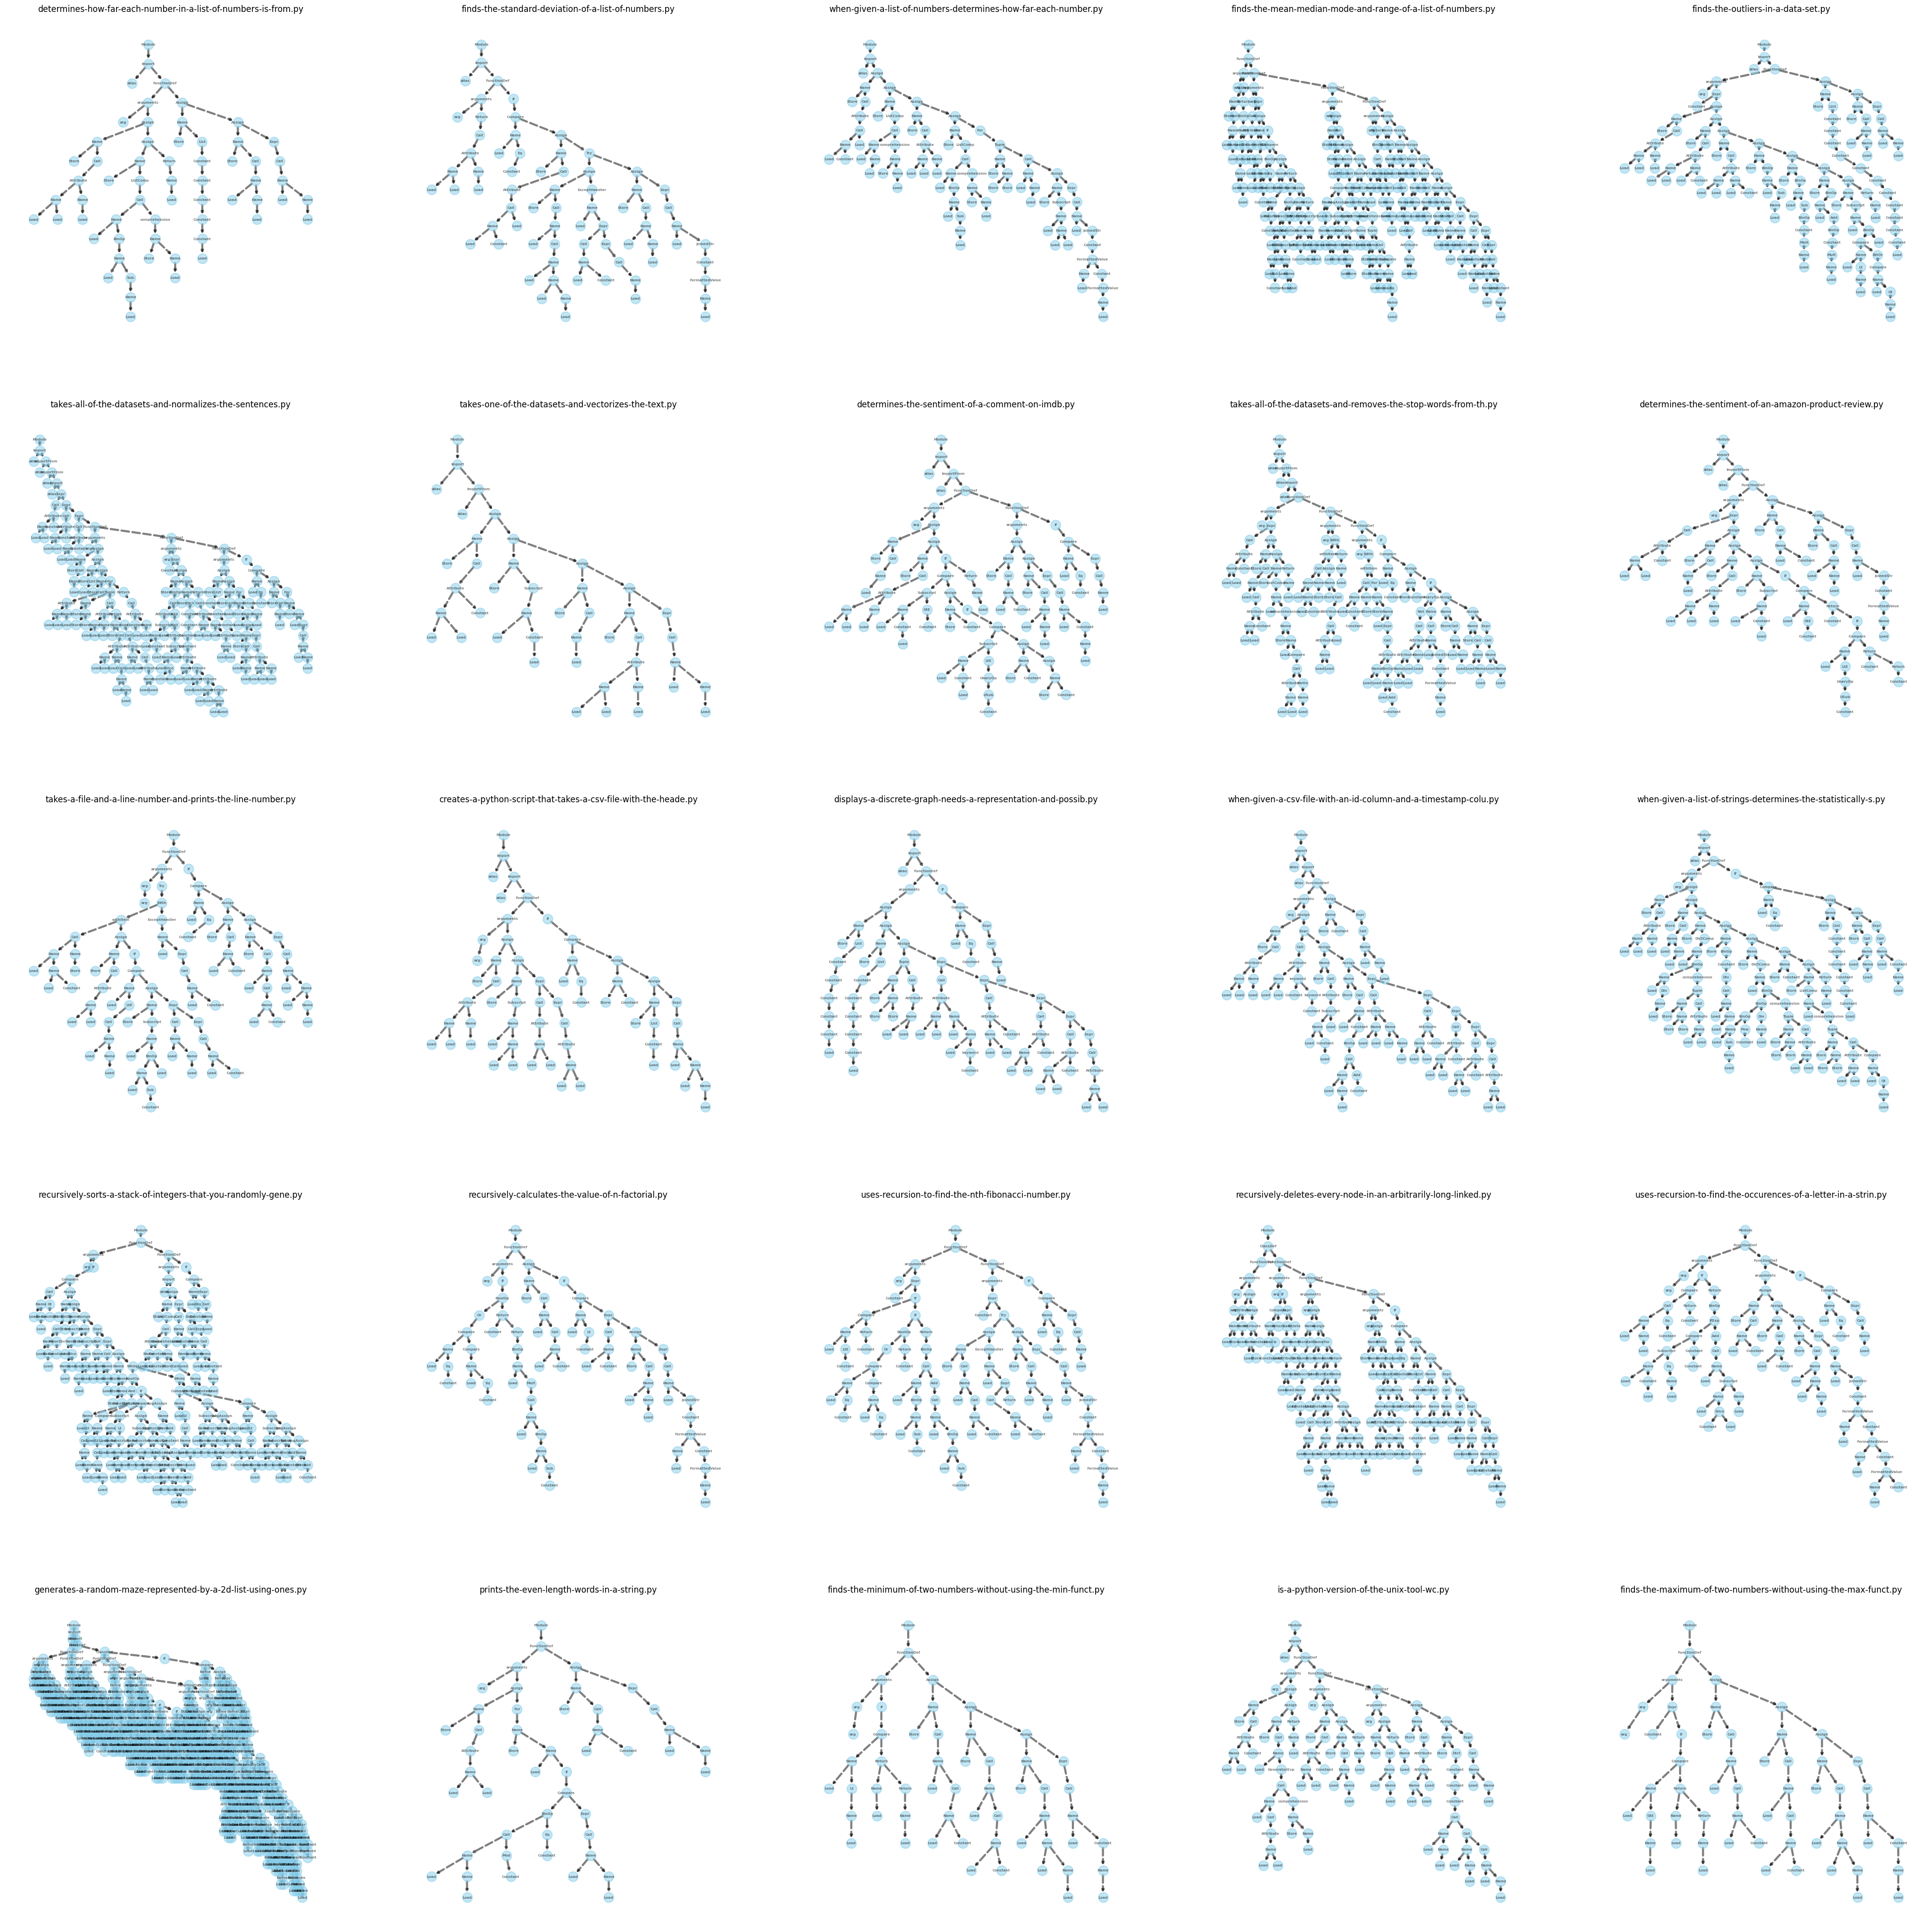

In [20]:
# Visualize some graphs from the ChatGPT dataset
from tqdm import tqdm
fig, ax = plt.subplots(5, 5, figsize=(50, 50))
for i in tqdm(range(5)):
    for j in range(5):
        plot_graph(ChatGPT_ast_df.iloc[i*10+j]['Graph'], label=ChatGPT_ast_df.iloc[i*10+j]['Filename'], ax =ax[i][j])